In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import pandas as pd
import math
import sklearn.preprocessing as sk
from tensorboardX import SummaryWriter
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import random

seed = 42
random.seed(seed)
torch.cuda.manual_seed_all(seed)

N = 10000
M = 100
c = 0.5
p = 0.9
k = np.random.randn(M)
u1 = np.random.randn(M)
u1 -= u1.dot(k) * k / np.linalg.norm(k)**2
u1 /= np.linalg.norm(u1) 
k /= np.linalg.norm(k) 
u2 = k
w1 = c*u1
w2 = c*(p*u1+np.sqrt((1-p**2))*u2)
X = np.random.normal(0, 1, (N, M))
eps1 = np.random.normal(0, 0.01)
eps2 = np.random.normal(0, 0.01)
Y1 = np.matmul(X, w1) + np.sin(np.matmul(X, w1))+eps1
Y2 = np.matmul(X, w2) + np.sin(np.matmul(X, w2))+eps2
split = list(np.random.permutation(N))

X_train = X[split[0:8000],:]
Y1_train = Y1[split[0:8000]]
Y2_train = Y2[split[0:8000]]
X_valid = X[8000:9000,:]
Y1_valid = Y1[8000:9000]
Y2_valid = Y2[8000:9000]
X_test = X[9000:10000,:]
Y1_test = Y1[9000:10000]
Y2_test = Y2[9000:10000]
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(Y1_train.shape)
print(Y2_train.shape)
print(Y1_valid.shape)
print(Y2_valid.shape)
print(Y1_test.shape)
print(Y2_test.shape)

X_train = torch.from_numpy(X_train)
X_train = X_train.float()
Y1_train = torch.tensor(Y1_train)
Y1_train = Y1_train.float()
Y2_train = torch.tensor(Y2_train)
Y2_train = Y2_train.float()

X_valid = torch.from_numpy(X_valid)
X_valid = X_valid.float()
Y1_valid = torch.tensor(Y1_valid)
Y1_valid = Y1_valid.float()
Y2_valid = torch.tensor(Y2_valid)
Y2_valid = Y2_valid.float()

X_test = torch.from_numpy(X_test)
X_test = X_test.float()
Y1_test = torch.tensor(Y1_test)
Y1_test = Y1_test.float()
Y2_test = torch.tensor(Y2_test)
Y2_test = Y2_test.float()

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(Y1_train.shape)
print(Y2_train.shape)
print(Y1_valid.shape)
print(Y2_valid.shape)
print(Y1_test.shape)
print(Y2_test.shape)

(8000, 100)
(1000, 100)
(1000, 100)
(8000,)
(8000,)
(1000,)
(1000,)
(1000,)
(1000,)
torch.Size([8000, 100])
torch.Size([1000, 100])
torch.Size([1000, 100])
torch.Size([8000])
torch.Size([8000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])


In [3]:
input_size, feature_size = X.shape
shared_layer_size = 64
tower_h1 = 32
tower_h2 = 16
output_size = 1
LR = 0.001
epoch = 50
mb_size = 100
cost1tr = []
cost2tr = []
cost1D = []
cost2D = []
cost1ts = []
cost2ts = []
costtr = []
costD = []
costts = []

class MTLnet(nn.Module):
    def __init__(self):
        super(MTLnet, self).__init__()
        self.sharedlayer = nn.Sequential(
            nn.Linear(feature_size, shared_layer_size),
            nn.ReLU(),
            nn.Dropout()
        )
        self.tower1 = nn.Sequential(
            nn.Linear(shared_layer_size, tower_h1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h1, tower_h2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h2, output_size)
        )
        self.tower2 = nn.Sequential(
            nn.Linear(shared_layer_size, tower_h1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h1, tower_h2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h2, output_size)
        )        

    def forward(self, x):
        h_shared = self.sharedlayer(x)
        out1 = self.tower1(h_shared)
        out2 = self.tower2(h_shared)
        return out1, out2

def random_mini_batches(XE, R1E, R2E, mini_batch_size = 10, seed = 42): 
    # Creating the mini-batches
    np.random.seed(seed)            
    m = XE.shape[0]                  
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_XE = XE[permutation,:]
    shuffled_X1R = R1E[permutation]
    shuffled_X2R = R2E[permutation]
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, int(num_complete_minibatches)):
        mini_batch_XE = shuffled_XE[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch_X1R = shuffled_X1R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_X2R = shuffled_X2R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    Lower = int(num_complete_minibatches * mini_batch_size)
    Upper = int(m - (mini_batch_size * math.floor(m/mini_batch_size)))
    if m % mini_batch_size != 0:
        mini_batch_XE = shuffled_XE[Lower : Lower + Upper, :]
        mini_batch_X1R = shuffled_X1R[Lower : Lower + Upper]
        mini_batch_X2R = shuffled_X2R[Lower : Lower + Upper]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    
    return mini_batches

Weightloss1 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)
Weightloss2 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)

params = [Weightloss1, Weightloss2]
MTL = MTLnet()
opt1 = torch.optim.Adam(MTL.parameters(), lr=LR)
opt2 = torch.optim.Adam(params, lr=LR)
loss_func = nn.MSELoss()
Gradloss = nn.L1Loss()

Iter-0; MTL loss: 0.999
Iter-1; MTL loss: 0.7617
Iter-2; MTL loss: 0.4451
Iter-3; MTL loss: 0.3781
Iter-4; MTL loss: 0.382
Iter-5; MTL loss: 0.3125
Iter-6; MTL loss: 0.3103
Iter-7; MTL loss: 0.3656
Iter-8; MTL loss: 0.3281
Iter-9; MTL loss: 0.2763
Iter-10; MTL loss: 0.2683
Iter-11; MTL loss: 0.2928
Iter-12; MTL loss: 0.2853
Iter-13; MTL loss: 0.2886
Iter-14; MTL loss: 0.2602
Iter-15; MTL loss: 0.3132
Iter-16; MTL loss: 0.2541
Iter-17; MTL loss: 0.2257
Iter-18; MTL loss: 0.225
Iter-19; MTL loss: 0.2732
Iter-20; MTL loss: 0.2698
Iter-21; MTL loss: 0.2661
Iter-22; MTL loss: 0.2529
Iter-23; MTL loss: 0.2487
Iter-24; MTL loss: 0.2584
Iter-25; MTL loss: 0.2952
Iter-26; MTL loss: 0.2292
Iter-27; MTL loss: 0.2489
Iter-28; MTL loss: 0.1914
Iter-29; MTL loss: 0.2553
Iter-30; MTL loss: 0.2541
Iter-31; MTL loss: 0.2369
Iter-32; MTL loss: 0.2355
Iter-33; MTL loss: 0.2288
Iter-34; MTL loss: 0.2026
Iter-35; MTL loss: 0.2324
Iter-36; MTL loss: 0.211
Iter-37; MTL loss: 0.2562
Iter-38; MTL loss: 0.2208


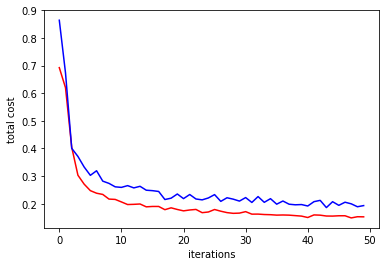

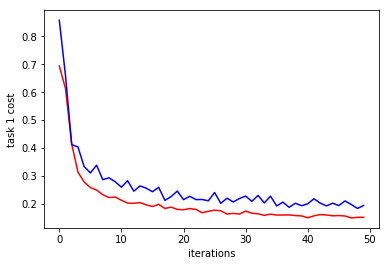

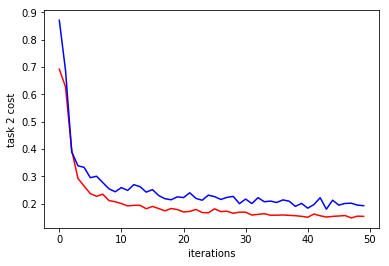

In [4]:
alph = 0.16
for it in range(epoch):
    epoch_cost = 0
    epoch_cost1 = 0
    epoch_cost2 = 0
    coef = 0
    num_minibatches = int(input_size / mb_size) 
    minibatches = random_mini_batches(X_train, Y1_train, Y2_train, mb_size)
    for minibatch in minibatches:
        XE, YE1, YE2  = minibatch 
        
        Yhat1, Yhat2 = MTL(XE)
        l1 = params[0]*loss_func(Yhat1, YE1.view(-1,1))    
        l2 = params[1]*loss_func(Yhat2, YE2.view(-1,1))
        loss = torch.div(torch.add(l1,l2), 2)

        # for the first epoch with no l0
        if it == 0:
            l0 = loss.data        
        
        opt1.zero_grad()
        
        loss.backward(retain_graph=True)   
        
        # Getting gradients of the first layers of each tower and calculate their l2-norm 
        param = list(MTL.parameters())
        G1R = torch.autograd.grad(l1, param[0], retain_graph=True, create_graph=True)
        G1 = torch.norm(G1R[0], 2)
        G2R = torch.autograd.grad(l2, param[0], retain_graph=True, create_graph=True)
        G2 = torch.norm(G2R[0], 2)
        G_avg = torch.div(torch.add(G1, G2), 2)
        
        # Calculating relative losses 
        lhat1 = torch.div(l1,l0)
        lhat2 = torch.div(l2,l0)
        lhat_avg = torch.div(torch.add(lhat1, lhat2), 2)
        
        # Calculating relative inverse training rates for tasks 
        inv_rate1 = torch.div(lhat1,lhat_avg)
        inv_rate2 = torch.div(lhat2,lhat_avg)
        
        # Calculating the constant target for Eq. 2 in the GradNorm paper
        C1 = G_avg*(inv_rate1)**alph
        C2 = G_avg*(inv_rate2)**alph
        C1 = C1.detach()
        C2 = C2.detach()
        
        opt2.zero_grad()
        # Calculating the gradient loss according to Eq. 2 in the GradNorm paper
        Lgrad = torch.add(Gradloss(G1, C1),Gradloss(G2, C2))
        Lgrad.backward()
        
        # Updating loss weights 
        opt2.step()

        # Updating the model weights
        opt1.step()

        # Renormalizing the losses weights
        coef = 2/torch.add(Weightloss1, Weightloss2)
        params = [coef*Weightloss1, coef*Weightloss2]
        #print("Weights are:",Weightloss1, Weightloss2)
        #print("params are:", params)
        epoch_cost = epoch_cost + (loss / num_minibatches)
        epoch_cost1 = epoch_cost1 + (l1 / num_minibatches)
        epoch_cost2 = epoch_cost2 + (l2 / num_minibatches)
        
    costtr.append(torch.mean(epoch_cost))
    cost1tr.append(torch.mean(epoch_cost1))
    cost2tr.append(torch.mean(epoch_cost2))
    
    with torch.no_grad():
        Yhat1D, Yhat2D = MTL(X_valid)
        l1D = params[0]*loss_func(Yhat1D, Y1_valid.view(-1,1))
        l2D = params[1]*loss_func(Yhat2D, Y2_valid.view(-1,1))
        cost1D.append(l1D)
        cost2D.append(l2D)
        costD.append(torch.add(l1D,l2D)/2)
        print('Iter-{}; MTL loss: {:.4}'.format(it, loss.item()))
        #print('Iter-{}; Grad loss: {:.4}'.format(it, Lgrad.item()))
    
plt.plot(np.squeeze(costtr),'-r',np.squeeze(costD), '-b')
plt.ylabel('total cost')
plt.xlabel('iterations')
plt.show() 

plt.plot(np.squeeze(cost1tr),'-r', np.squeeze(cost1D), '-b')
plt.ylabel('task 1 cost')
plt.xlabel('iterations')
plt.show() 

plt.plot(np.squeeze(cost2tr),'-r', np.squeeze(cost2D),'-b')
plt.ylabel('task 2 cost')
plt.xlabel('iterations')
plt.show()

In [5]:
print(params)

[tensor([ 0.9967]), tensor([ 1.0033])]
